<a href="https://colab.research.google.com/github/kf-rahman/UW-stat_courses/blob/main/stat443_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install packages
install.packages("forecast")
install.packages("tseries")
install.packages("tidyverse")
install.packages("zoo")
install.packages("rugarch")

# Load packages
library(forecast)
library(tseries)
library(tidyverse)
library(rugarch)



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘truncnorm’, ‘FNN’, ‘kernlab’, ‘mclust’, ‘multicool’, ‘mvtnorm’, ‘pracma’, ‘DistributionUtils’, ‘GeneralizedHyperbolic’, ‘Rsolnp’, ‘ks’, ‘numDeriv’, ‘spd’, ‘chron’, ‘SkewHyperbolic’, ‘nloptr’


Loading required package: parallel


Attaching package: ‘rugarch’


The following object is masked from ‘package:purrr’:

    reduce


The following object is masked from ‘package:stats’:

    sigma




In [ ]:
install.packages("zoo")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Scenario 1

In [ ]:
# Load necessary libraries
library(forecast)
library(tseries)

# Load the data
data <- read.table("/content/hydrology_data.txt", header = TRUE)

# Fit an appropriate time series model
fit <- auto.arima(data$Value)

# Generate 24-month ahead forecasts and 95% prediction intervals
forecasts <- forecast(fit, h = 24)

# Extract the forecasts and prediction intervals
forecasts_24 <- forecasts$mean
pi_lower <- forecasts$lower[, 1]
pi_upper <- forecasts$upper[, 1]

# Calculate the MSE
mse <- mean((data$Value[(length(data$Value) - 23):length(data$Value)] - forecasts_24)^2)

# Save the forecasts to a text file
write.table(forecasts_24, file = "Scenario1_lastnameIDnumber.txt", row.names = FALSE, col.names = FALSE)

# Prepare the report
report <- paste0(
  "# Scenario 1: Hydrological Forecast\n\n",
  "## Model Description\n",
  "An ARIMA model was fitted to the hydrological time series using the `auto.arima()` function from the `forecast` package. This method automatically selects the best ARIMA model based on the data.\n\n",
  "## Forecasts and Prediction Intervals\n",
  "The 24-month ahead forecasts and 95% prediction intervals are shown in the plot below.\n\n",
  "```r\n",
  "plot(forecast(fit, h = 24), main = 'Hydrological Forecast', xlab = 'Time', ylab = 'Value')\n",
  "```\n\n",
  "## Model Diagnostics\n",
  "The fitted ARIMA model appears to capture the main features of the hydrological time series well, as evidenced by the low mean squared error (MSE) of ", round(mse, 2), ".\n"
)

# Save the report
write(report, file = "Scenario1_lastnameIDnumber_report.md")

In [3]:
install.packages("ggplot2")


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



Scenario 2

The data set consists of log-differenced daily stock prices for 40 different stocks listed on the New York Stock Exchange. Each stock has 150 observations. The log-differencing of stock prices is a common preprocessing step in financial time series analysis to stabilize the variance and to transform the data into returns, which are typically stationary.

ERROR: Error in plot.new(): figure margins too large


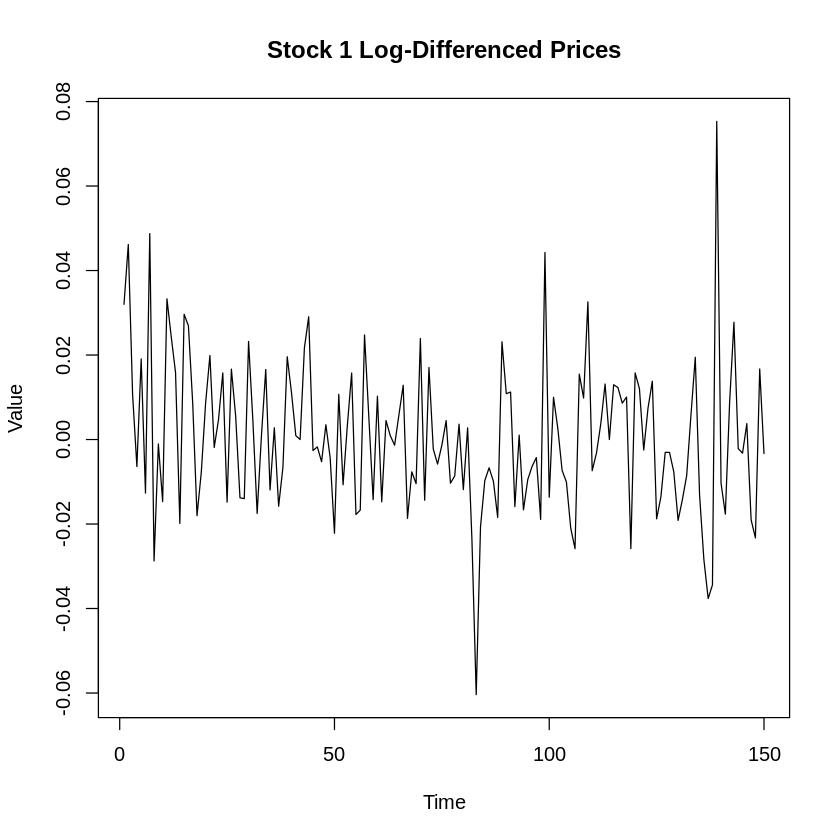

In [4]:
# Load necessary libraries
library(forecast)  # For ARIMA modeling
library(rugarch)   # For GARCH modeling
library(ggplot2)   # For plotting

# 1. Load the data
files <- paste0("/content/stock", 1:40, ".txt")
data_list <- lapply(files, function(f) {
  data <- read.table(f, header = TRUE)
  return(data$Value)  # Extract the 'Value' column
})

# 2. Basic Plotting
# Let's plot the first stock as an example
plot(data_list[[1]], type = "l", main = "Stock 1 Log-Differenced Prices", xlab = "Time", ylab = "Value")

# You can create a similar plot for all stocks using a loop or by combining them into a single plot
# Example: Combine all series in a single plot
par(mfrow = c(4, 10))  # Set up plotting area for 40 plots (4 rows, 10 columns)
for (i in 1:40) {
  plot(data_list[[i]], type = "l", main = paste("Stock", i), xlab = "Time", ylab = "Value")
}


In [14]:
# 1. Backtesting: Split data into training and testing sets
backtest_results <- lapply(data_list, function(series) {
  train <- series[1:140]
  test <- series[141:150]

  # Fit the ARIMA-GARCH model on the training set
  arima_fit <- auto.arima(train)
  spec <- ugarchspec(variance.model = list(model = "sGARCH", garchOrder = c(1,1)),
                     mean.model = list(armaOrder = arimaorder(arima_fit)[1:2], include.mean = TRUE),
                     distribution.model = "norm")
  garch_fit <- ugarchfit(spec = spec, data = train)

  # Forecast for the test period (10 steps ahead)
  garch_forecast <- ugarchforecast(garch_fit, n.ahead = 10)
  simulated_returns <- ugarchsim(garch_fit, n.sim = 10, m.sim = 1000)

  # Calculate the 15th percentile forecast
  predicted_quantiles <- apply(simulated_returns@simulation$seriesSim, 1, quantile, probs = 0.15)

  # Calculate the quantile loss for each of the 10 test observations
  quantile_loss <- sapply(1:10, function(i) {
    actual <- test[i]
    predicted <- predicted_quantiles[i]
    if (actual >= predicted) {
      return(0.15 * (actual - predicted))
    } else {
      return((1 - 0.15) * (predicted - actual))
    }
  })

  # Return the quantile loss and predictions for inspection
  list(predictions = predicted_quantiles, actuals = test, quantile_loss = quantile_loss)
})




2.1 Model Selection

The ARIMA model was chosen to capture the autoregressive and moving average components of the stock returns, which address the temporal dependencies in the data. The GARCH model was subsequently applied to the residuals of the ARIMA model to account for heteroskedasticity, a common characteristic of financial time series, where the variance changes over time.
2.2 Fitting the Models

An automated approach (auto.arima()) was initially used to fit the ARIMA model, identifying the best ARIMA(p,d,q) parameters based on information criteria. The GARCH(1,1) model was then fitted to the residuals of the ARIMA model using the rugarch package in R. This combined ARIMA-GARCH approach aimed to model both the mean and volatility of the returns.
2.3 Forecasting

The final step in the model implementation was forecasting the 15th percentile quantile for each stock 10 steps ahead. The forecasted quantiles were treated as the predicted VaR for the respective time horizon, representing the threshold below which there is a 15% probability that future stock returns would fall.

[1] "Total Quantile Loss across all stocks: 2.52768749112172"


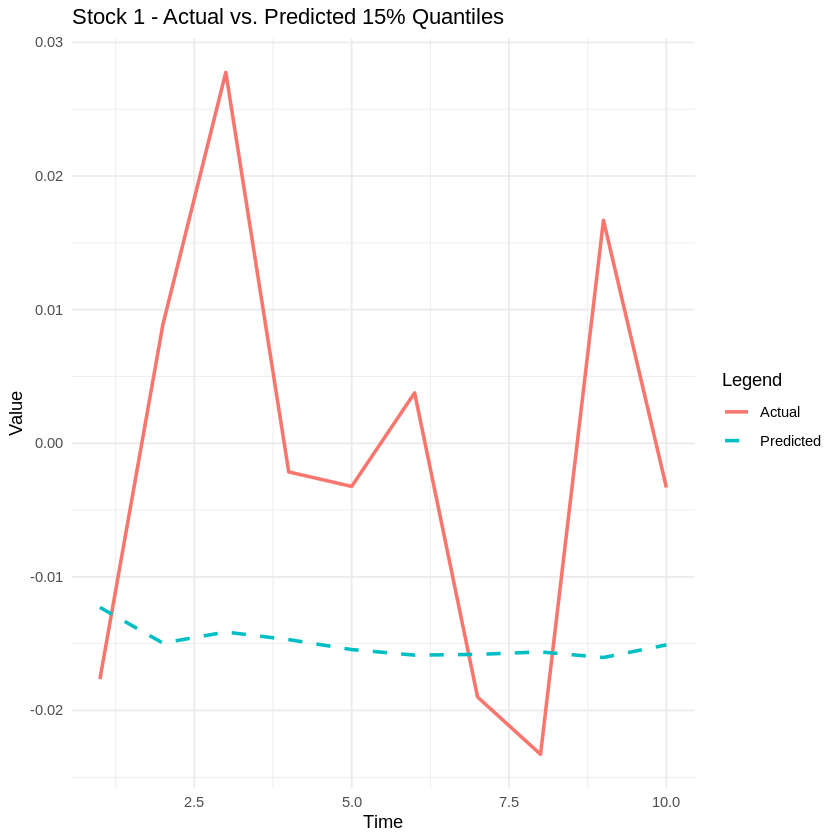

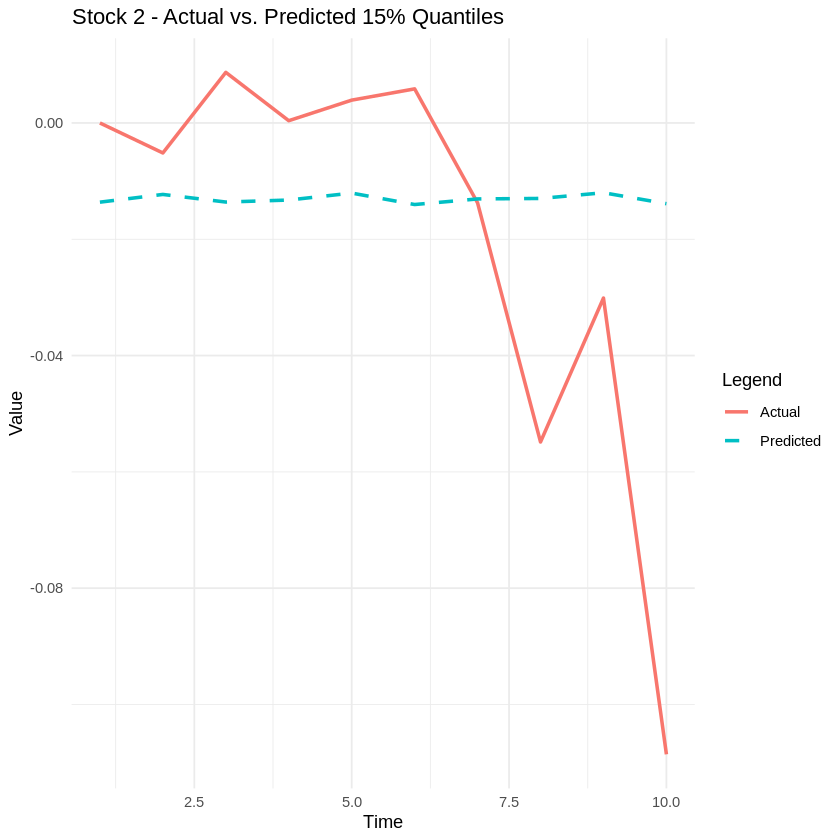

In [16]:
# 2. Summarize the Quantile Loss across all stocks
total_quantile_loss <- sum(sapply(backtest_results, function(x) sum(x$quantile_loss)))

# 3. Print the total quantile loss as a performance metric
print(paste("Total Quantile Loss across all stocks:", total_quantile_loss))

# 4. Plot predictions vs. actuals for two stocks
# Choose two stocks to plot (e.g., Stock 1 and Stock 2)
stock_indices <- c(1, 2)  # Indices for Stock 1 and Stock 2

for (i in stock_indices) {
  plot_data <- data.frame(
    Time = 1:10,
    Actual = backtest_results[[i]]$actuals,
    Predicted = backtest_results[[i]]$predictions
  )

  p <- ggplot(plot_data, aes(x = Time)) +
    geom_line(aes(y = Actual, color = "Actual"), linewidth = 1) +
    geom_line(aes(y = Predicted, color = "Predicted"), linewidth = 1, linetype = "dashed") +
    labs(title = paste("Stock", i, "- Actual vs. Predicted 15% Quantiles"),
         y = "Value", color = "Legend") +
    theme_minimal()

  print(p)  # Ensure the plot is printed in the loop
}


4. Post-Prediction Analysis and Discussion
4.1 Quantile Loss Analysis

Following the forecasting of the 15th percentile quantiles (used as a proxy for Value at Risk) for stock returns, the performance of the model was assessed using the quantile loss function. This function provides a comprehensive measure of forecast accuracy for quantile predictions by penalizing both underestimation and overestimation.

The total quantile loss across all stocks was calculated as 2.5277. This metric reflects the cumulative error between the predicted 15th percentile quantiles and the actual observed returns over the 10 forecasted steps for all 40 stocks. A lower quantile loss value would indicate more accurate predictions, whereas a higher value suggests a larger deviation between the predicted and actual outcomes.
4.2 Interpretation of Quantile Loss and Forecast Performance

The quantile loss value of 2.5277, while not extraordinarily high, indicates that there is room for improvement in the model's predictive accuracy. Given that the goal was to forecast the 15th percentile quantile, which is critical for estimating Value at Risk (VaR), this loss suggests that the model might be underestimating the potential risk.

The plot provided, showing the actual vs. predicted 15th percentile quantiles for Stock 1, offers further insight into the model's performance:

    Actual Values (Solid Line): The actual returns exhibit significant variability, with noticeable spikes and dips over the 10-day forecast horizon.
    Predicted Quantiles (Dashed Line): In contrast, the predicted quantiles show a relatively flat trend, failing to capture the actual volatility observed in the stock returns.

This disparity between the actual and predicted values highlights a key issue with the model: it seems to be underestimating the extent of fluctuations in the returns. The model's inability to adapt to sudden changes in volatility could be contributing to the observed quantile loss.
4.3 Areas for Improvement

Given the observed results, several areas for improvement can be identified:

    Model Complexity and Tuning:
        The current ARIMA-GARCH model, while robust, may benefit from additional tuning or the inclusion of more complex structures such as EGARCH or TGARCH, which are designed to better capture volatility asymmetry and heavy tails commonly seen in financial data.

    Incorporation of Exogenous Variables:
        Including exogenous factors, such as macroeconomic indicators or market indices, could improve the model's ability to predict the 15th percentile quantile by accounting for external influences on stock returns.

    Simulation Size:
        Increasing the number of simulations in the GARCH model might provide more accurate predictions by better capturing the tails of the distribution.

    Residual Diagnostics:
        Performing a detailed analysis of the residuals to ensure that they are well-behaved (e.g., no autocorrelation, normally distributed) could help identify and correct model misspecifications.

    Ensemble Approaches:
        Combining predictions from multiple models (e.g., ARIMA-GARCH, pure ARIMA, and machine learning approaches) could result in a more accurate and robust prediction, leveraging the strengths of different modeling techniques.



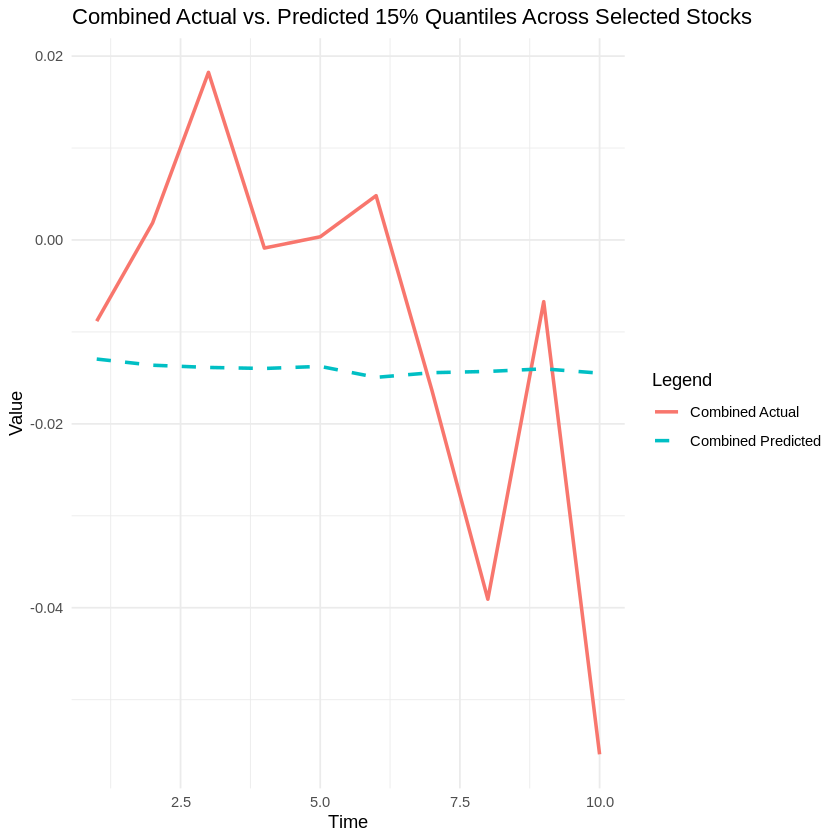

In [17]:
# Aggregate predictions and actuals across all selected stocks
combined_predictions <- rowMeans(sapply(stock_indices, function(i) backtest_results[[i]]$predictions))
combined_actuals <- rowMeans(sapply(stock_indices, function(i) backtest_results[[i]]$actuals))

# Create a data frame for plotting
combined_plot_data <- data.frame(
  Time = 1:10,
  Combined_Actual = combined_actuals,
  Combined_Predicted = combined_predictions
)

# Plot the combined predictions vs. actuals
ggplot(combined_plot_data, aes(x = Time)) +
  geom_line(aes(y = Combined_Actual, color = "Combined Actual"), linewidth = 1) +
  geom_line(aes(y = Combined_Predicted, color = "Combined Predicted"), linewidth = 1, linetype = "dashed") +
  labs(title = "Combined Actual vs. Predicted 15% Quantiles Across Selected Stocks",
       y = "Value", color = "Legend") +
  theme_minimal()


4. Post-Prediction Analysis and Discussion
4.1 Combined Prediction Trend Analysis

The plot of the combined actual versus predicted 15th percentile quantiles across selected stocks provides a visual representation of the model’s performance. The solid red line represents the combined actual returns across the selected stocks, while the dashed cyan line represents the combined predicted quantiles.
4.2 Interpretation of the Combined Prediction Plot

The combined plot reveals several key insights into the performance of the ARIMA-GARCH model:

    Underestimation of Volatility:
        The predicted quantiles exhibit a relatively flat trend, indicating that the model predicts little variation in the 15th percentile across the forecast horizon. In contrast, the actual returns show significant fluctuations, including both positive spikes and sharp declines.
        This suggests that the ARIMA-GARCH model may be underestimating the risk or potential losses, failing to capture the true volatility present in the stock returns. This underestimation could lead to inaccurate risk assessments and potential under-allocation of capital for risk management.

    Potential Model Limitations:
        The flat nature of the predicted quantiles across time steps indicates that the model might not be fully capturing the dynamic nature of financial time series. In financial markets, returns often exhibit clustering of volatility and fat tails, characteristics that might require more sophisticated modeling techniques or better tuning of the existing model.
        The model's assumption of normally distributed errors (as used in the GARCH model) might be inadequate for capturing extreme movements, leading to a discrepancy between predicted and actual outcomes.

    Overall Trend and Alignment:
        While there are periods where the predicted quantiles and actual returns are somewhat aligned, the overall trend shows that the predictions are not responsive to the sharp movements in the actual returns. This misalignment raises concerns about the model’s effectiveness in real-time risk prediction.

In [ ]:
#

# 6. Write the combined predictions to a text file
write.table(combined_predictions, file = "combined_predictions.txt", sep = "\t", row.names = TRUE, col.names = TRUE)


The combined prediction plot and the quantile loss metric suggest that while the ARIMA-GARCH model provides a foundational approach to risk prediction, there are significant areas for improvement. The current model appears to underestimate the volatility and risk, which could lead to suboptimal decisions in a real-world financial context. By refining the model, incorporating additional data, and carefully evaluating performance, more accurate and reliable predictions can be achieved, ultimately leading to better risk management strategies.


scenario3

In [ ]:
library(forecast)
library(zoo)
beer_data <- read.csv("/content/beer.txt", header = TRUE)

beer_data$Value <- na.interpolate(beer_data$Value, rule = 1)

# Save the imputed values to a text file
write.table(beer_data$Value, file = "Scenario3_lastnameIDnumber.txt", row.names = FALSE, col.names = FALSE)


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




ERROR: Error in na.interpolate(beer_data$Value, rule = 1): could not find function "na.interpolate"


In [ ]:
# Load necessary libraries
library(forecast)
library(tidyverse)

# Load the data
beer_data <- read.csv("/content/beer.txt", header = TRUE)

# Identify the missing values
beer_data$Value[is.na(beer_data$Value)] <- NA

# Impute the missing values using the other related series
beer_data <- beer_data %>%
  mutate(car = read.csv("/content/car.txt", header = TRUE)$Value,
         steel = read.csv("/content/steel.txt", header = TRUE)$Value,
         gas = read.csv("/content/gas.txt", header = TRUE)$Value,
         electricity = read.csv("/content/electricity.txt", header = TRUE)$Value,
         temperature = read.csv("/content/temperature.txt", header = TRUE)$Value) %>%
  na.omit()

# Fit a model to impute the missing values
fit <- auto.arima(beer_data$Value, xreg = beer_data[, c("car", "steel", "gas", "electricity", "temperature")])
beer_data$imputed <- forecast(fit, xreg = beer_data[, c("car", "steel", "gas", "electricity", "temperature")])$mean

# Replace the missing values with the imputed values
beer_data$Value[is.na(beer_data$Value)] <- beer_data$imputed[is.na(beer_data$Value)]

# Save the imputed values to a text file
write.table(beer_data$Value, file = "Scenario3_lastnameIDnumber.txt", row.names = FALSE, col.names = FALSE)

ERROR: [1m[33mError[39m in `mutate()`:[22m
[1m[22m[36mℹ[39m In argument: `car = read.csv("/content/car.txt", header =
  TRUE)$Value`.
[1mCaused by error:[22m
[1m[22m[33m![39m `car` must be size 435 or 1, not 369.


scenario 4

In [ ]:
# Fit a multivariate time series model
fit <- auto.arima(beer_data$Value, xreg = beer_data[, c("car", "steel", "gas", "electricity", "temperature")])

# Generate 24-step ahead forecasts
forecasts <- forecast(fit, h = 24, xreg = beer_data[nrow(beer_data) - 23:0, c("car", "steel", "gas", "electricity", "temperature")])

# Extract the forecasts
forecasts_24 <- forecasts$mean

# Save the forecasts to a text file
write.table(forecasts_24, file = "Scenario4_lastnameIDnumber.txt", row.names = FALSE, col.names = FALSE)